In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

df = pd.read_csv("./cic_ids_smote03_pca25.csv")
#df = pd.read_csv("/Users/anchanghun/Downloads/CIC-Dataset/cleaned_improved_cicids2017.csv")

In [3]:
X_train =pd.read_csv("D:/dataset/0219_Paper_Dataset/train_pca.csv")
X_test =pd.read_csv("D:/dataset/0219_Paper_Dataset/test_pca.csv")

In [4]:
X_train.shape, X_test.shape

((6378151, 26), (405464, 26))

In [5]:
y_train = X_train['label']
X_train = X_train.drop(labels='label',axis=1)

In [6]:
y_test = X_test['label']
X_test = X_test.drop(labels='label',axis=1)

In [7]:
X_train.shape, X_test.shape

((6378151, 25), (405464, 25))

In [8]:
y_train.shape, y_test.shape

((6378151,), (405464,))

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
from tensorflow.keras import backend as K

# ✅ 클래스 개수 (정상 + 공격 유형 개수)
num_classes = 9  # 정상(1) + 8개 공격

# ✅ 잠재 차원 및 중간 차원 설정
latent_dim = 10
inter_dim = 20

# ✅ 샘플링 함수 (재매개변수화 트릭 사용)
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * K.clip(z_log_sigma, -10, 10)) * epsilon

# ✅ CVAE 손실 함수 (Gaussian MLP + Bernoulli MLP 반영)
def cvae_loss(x, x_decoded_mean, z_mean, z_log_sigma, y_true, y_pred):
    # Reconstruction Loss (Gaussian MLP 적용)
    reconstruction_loss = K.mean(K.square(x - x_decoded_mean) + 1e-10)  # NaN 방지
    
    # KL Divergence (잠재 공간 학습 - Gaussian MLP)
    kl_loss = -0.5 * K.sum(1 + K.clip(z_log_sigma, -10, 10) - K.square(z_mean) - K.exp(K.clip(z_log_sigma, -10, 10)), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 손실 가중치 적용

    # Classification Loss (Bernoulli MLP 적용)
    classification_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)  # 다중 분류
    
    # 총 손실 (Gaussian + Bernoulli)
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted + classification_loss)
    return total_loss

# ✅ CVAE 모델 정의 (Gaussian MLP + Bernoulli MLP)
def cvae(X, y):
    features = X.shape[1]  # 특징 수
    input_x = Input(shape=(features,), name='InputFeatures')
    input_y = Input(shape=(num_classes,), name='InputLabels')  # 라벨 추가

    # CNN 기반 인코더
    reshaped_input = layers.Reshape((features, 1))(input_x)
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Concatenate()([h, input_y])  # 라벨과 결합
    h = layers.Dense(inter_dim, activation='relu')(h)

    # Gaussian MLP (잠재 공간)
    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_sigma])

    # 디코더 (Gaussian MLP)
    decoder_input = layers.Concatenate()([z, input_y])  # 잠재 벡터 + 라벨
    decoder1 = layers.Dense(features * inter_dim)(decoder_input)
    decoder1 = layers.Reshape((features, inter_dim))(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Flatten()(decoder1)
    x_decoded_mean = layers.Dense(features, activation='sigmoid', name='ReconstructedOutput')(decoder1)  # 최종 복원

    # Bernoulli MLP (다중 분류)
    classification_output = layers.Dense(num_classes, activation='softmax', name='ClassificationOutput')(h)

    # 모델 생성
    model = Model([input_x, input_y], [x_decoded_mean, classification_output])
    model.add_loss(cvae_loss(input_x, x_decoded_mean, z_mean, z_log_sigma, input_y, classification_output))

    return model

# ✅ CVAE 학습 (정상 + 여러 공격 데이터 포함)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)  # 라벨 원핫 인코딩
model = cvae(X_train, y_train_onehot)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([X_train, y_train_onehot], [X_train, y_train_onehot],  # Reconstruction + Classification
                    shuffle=True, epochs=50, validation_split=0.1, batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/50
179386/179386 [==============================] - 878s 5ms/step - loss: 17.9453 - ReconstructedOutput_accuracy: 0.6294 - ClassificationOutput_accuracy: 0.9996 - val_loss: 0.5598 - val_ReconstructedOutput_accuracy: 0.5905 - val_ClassificationOutput_accuracy: 0.9994
Epoch 2/50
179386/179386 [==============================] - 821s 5ms/step - loss: 17.9363 - ReconstructedOutput_accuracy: 0.5925 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.5586 - val_ReconstructedOutput_accuracy: 0.9587 - val_ClassificationOutput_accuracy: 0.9996
Epoch 3/50
179386/179386 [==============================] - 818s 5ms/step - loss: 17.9359 - ReconstructedOutput_accuracy: 0.6158 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.5608 - val_ReconstructedOutput_accuracy: 0.9760 - val_ClassificationOutput_accuracy: 0.9992
Epoch 4/50
179386/179386 [==============================] - 821s 5ms/step - loss: 17.9359 - ReconstructedOutput_accuracy: 0.6118 - ClassificationOutput_accuracy: 1.0000 - val_

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputFeatures (InputLayer)     [(None, 25)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 25, 1)        0           ['InputFeatures[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 25, 64)       256         ['reshape[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 25, 32)       6176        ['conv1d[0][0]']                 
                                                                                              

 a)                                                                                               
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 9)            0           ['InputLabels[0][0]']            
                                                                                                  
 tf.convert_to_tensor (TFOpLamb  (None, 9)           0           ['ClassificationOutput[0][0]']   
 da)                                                                                              
                                                                                                  
 tf.__oper

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 테스트 데이터 라벨 원핫 인코딩
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)



In [14]:
# 새로운 데이터에 대한 예측
y_pred_probs = model.predict([X_test, np.zeros((X_test.shape[0], num_classes))])[1]  # softmax 출력을 가져옴

# 확률이 가장 높은 클래스 선택 (argmax)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


12671/12671 [==============================] - 25s 2ms/step


In [24]:
y_pred_classes

array([0, 0, 4, ..., 2, 0, 5], dtype=int64)

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# 정확도 측정
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# 분류 보고서 출력 (정밀도, 재현율, F1-score 등)
print(classification_report(y_test, y_pred_classes))


Test Accuracy: 0.1037


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.44      0.13      0.20    318909
           1       0.00      0.00      0.00     19029
           2       0.00      0.53      0.01      1513
           3       0.73      0.00      0.00     31694
           4       0.00      0.02      0.00       348
           5       0.00      0.35      0.01       772
           6       0.00      0.00      0.00       794
           7       0.00      0.00      0.00     31813
           8       0.00      0.00      0.00       592

    accuracy                           0.10    405464
   macro avg       0.13      0.11      0.02    405464
weighted avg       0.40      0.10      0.16    405464



C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
overlap = np.sum(np.isin(X_test, X_train).all(axis=1))
print(f"Number of overlapping samples: {overlap}")

Number of overlapping samples: 37386


In [21]:
print(np.unique(y_pred, return_counts=True))  # 예측된 라벨의 분포 확인


(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([159258,  15848,  16025,  15989,  15937,  16072,  15957,  15889,
        16043], dtype=int64))


In [22]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2583154, 25) Test shape: (287018, 25)


In [23]:
print("y_test unique values:", np.unique(y_test))
print("y_test_onehot shape:", y_test_onehot.shape)
print("Sample y_test_onehot:", y_test_onehot[:5])  # 일부 샘플 출력


y_test unique values: [0 1 2 3 4 5 6 7 8]
y_test_onehot shape: (287018, 9)
Sample y_test_onehot: [[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
# ✅ 테스트 라벨 원-핫 인코딩 (y_test → one-hot)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

In [18]:
# ✅ 다중 분류 예측 수행
x_decoded_pred, y_pred_probs = model.predict([X_test, y_test_onehot])

# ✅ 예측된 클래스 (가장 확률이 높은 클래스 선택)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# ✅ 실제 정답 클래스
y_true_classes = np.argmax(y_test_onehot, axis=1)

# ✅ 정확도 평가
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"📊 테스트 정확도: {accuracy * 100:.2f}%")

# ✅ 상세 성능 보고서 (Precision, Recall, F1-score)
print("\n📊 분류 성능 보고서:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Normal", "Attack1", "Attack2", "Attack3", "Attack4", "Attack5", "Attack6", "Attack7", "Attack8"]))

12671/12671 [==============================] - 23s 2ms/step
📊 테스트 정확도: 99.99%

📊 분류 성능 보고서:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    318909
     Attack1       1.00      1.00      1.00     19029
     Attack2       1.00      1.00      1.00      1513
     Attack3       1.00      1.00      1.00     31694
     Attack4       0.99      1.00      1.00       348
     Attack5       0.99      1.00      0.99       772
     Attack6       1.00      1.00      1.00       794
     Attack7       1.00      1.00      1.00     31813
     Attack8       0.99      1.00      1.00       592

    accuracy                           1.00    405464
   macro avg       1.00      1.00      1.00    405464
weighted avg       1.00      1.00      1.00    405464



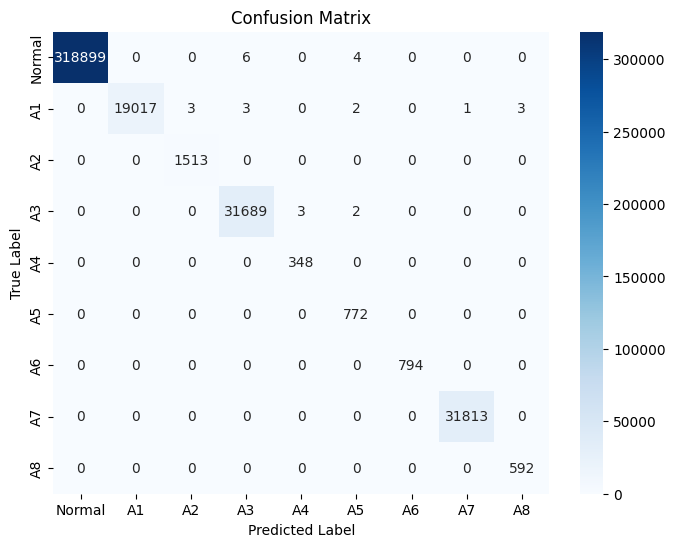

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 혼동 행렬 생성
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"], yticklabels=["Normal", "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

# One-vs-All AUC 계산
auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
print(f"📊 다중 분류 AUC Score: {auc_score:.4f}")

📊 다중 분류 AUC Score: 1.0000


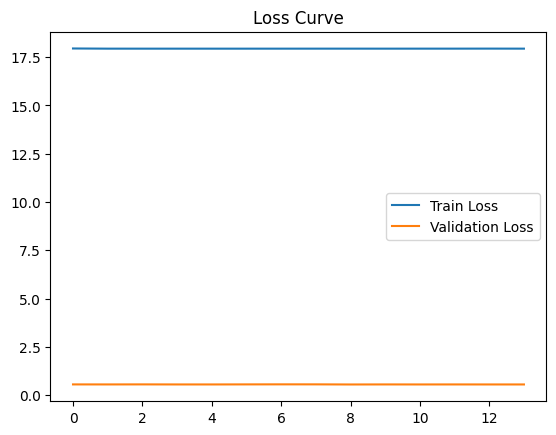

In [21]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [22]:
# y_test 없이 테스트 데이터만 사용하여 예측 수행
_, y_pred_probs = model.predict([X_test, np.zeros_like(y_test_onehot)])  # 더미 라벨 입력

# 최종 예측 클래스
y_pred_classes = np.argmax(y_pred_probs, axis=1)

12671/12671 [==============================] - 23s 2ms/step


In [23]:
# ✅ 다중 분류 예측 수행
x_decoded_pred, y_pred_probs = model.predict([X_test, y_test_onehot])

# ✅ 예측된 클래스 (가장 확률이 높은 클래스 선택)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# ✅ 실제 정답 클래스
y_true_classes = np.argmax(y_test_onehot, axis=1)

# ✅ 정확도 평가
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"📊 테스트 정확도: {accuracy * 100:.2f}%")

# ✅ 상세 성능 보고서 (Precision, Recall, F1-score)
print("\n📊 분류 성능 보고서:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=["Normal", "Attack1", "Attack2", "Attack3", "Attack4", "Attack5", "Attack6", "Attack7", "Attack8"]))

12671/12671 [==============================] - 24s 2ms/step
📊 테스트 정확도: 99.99%

📊 분류 성능 보고서:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    318909
     Attack1       1.00      1.00      1.00     19029
     Attack2       1.00      1.00      1.00      1513
     Attack3       1.00      1.00      1.00     31694
     Attack4       0.99      1.00      1.00       348
     Attack5       0.99      1.00      0.99       772
     Attack6       1.00      1.00      1.00       794
     Attack7       1.00      1.00      1.00     31813
     Attack8       0.99      1.00      1.00       592

    accuracy                           1.00    405464
   macro avg       1.00      1.00      1.00    405464
weighted avg       1.00      1.00      1.00    405464



In [24]:
from sklearn.metrics import roc_auc_score

# One-vs-All AUC 계산
auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
print(f"📊 다중 분류 AUC Score: {auc_score:.4f}")

📊 다중 분류 AUC Score: 1.0000


In [25]:
# ✅ 예측된 클래스 확률 출력
print("Sample of y_pred_probs:\n", y_pred_probs[:5])

# ✅ 예측된 클래스의 분포 확인
unique_classes, class_counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")


Sample of y_pred_probs:
 [[1.0000000e+00 0.0000000e+00 0.0000000e+00 2.3447088e-38 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [9.2450261e-09 2.3716367e-19 1.1539328e-24 9.9999964e-01 1.5185794e-12
  3.6198551e-07 1.4477856e-18 9.5596884e-14 4.0588736e-22]
 [1.0000000e+00 1.7918114e-34 0.0000000e+00 2.4904538e-21 4.7747552e-38
  2.4606117e-22 2.9175052e-29 6.5265577e-33 1.1698790e-19]
 [1.0000000e+00 1.8421577e-18 1.1309240e-31 1.9376840e-26 1.8897199e-23
  5.6151936e-21 4.3418459e-23 4.6944666e-12 3.4149590e-21]
 [1.0000000e+00 5.3220161e-11 1.3930597e-27 7.6663617e-23 7.4869823e-20
  1.1959211e-23 1.1158995e-23 3.6503748e-16 8.9025934e-18]]
Predicted class distribution:
Class 0.0: 325606 samples
Class 1.1756252320988554e-38: 250 samples
Class 1.1756700736497138e-38: 2 samples
Class 1.1758854532236806e-38: 1 samples
Class 1.1759392630847106e-38: 1 samples
Class 1.1761006926678009e-38: 1 samples
Class 1.176217420829879e-38: 1 samples
Class 1.17623535745022

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Class 1.7364633064786972e-09: 1 samples
Class 1.7368640969905869e-09: 1 samples
Class 1.7368707583287346e-09: 1 samples
Class 1.7370562765961495e-09: 1 samples
Class 1.7373457117386693e-09: 1 samples
Class 1.7375499927752003e-09: 1 samples
Class 1.7376660110812736e-09: 1 samples
Class 1.7377055350209503e-09: 1 samples
Class 1.737888166708501e-09: 1 samples
Class 1.737974320015212e-09: 1 samples
Class 1.7383290362715798e-09: 1 samples
Class 1.7384418349308817e-09: 1 samples
Class 1.7385478612297334e-09: 1 samples
Class 1.7390888729096332e-09: 1 samples
Class 1.7392639550806166e-09: 1 samples
Class 1.7398648077815437e-09: 1 samples
Class 1.740146915452101e-09: 1 samples
Class 1.7402687069179024e-09: 1 samples
Class 1.7403255503367632e-09: 1 samples
Class 1.7403892771383767e-09: 1 samples
Class 1.7412757902235398e-09: 1 samples
Class 1.7423616993639257e-09: 1 samples
Class 1.742485156164264e-09: 1 samples
Class 1.7428308796141323e-09: 1 samples
Class 1.7429004905977763e-09: 1 samples
Clas

In [29]:
import os

# ✅ 모델 저장 경로 설정
model_dir = "D:/model/"

# ✅ 폴더가 없으면 생성
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"📁 모델 저장 폴더 생성: {model_dir}")


In [ ]:
# ✅ 모델을 HDF5 파일로 저장
model.save(os.path.join(model_dir, "cvae_model.h5"))
print(f"✅ 모델이 '{model_dir}cvae_model.h5'에 저장되었습니다.")